In [134]:
import numpy as np
import scipy
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

In [135]:
import numpy as np
import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.cross_validation import StratifiedKFold
import IPython.display as ipd
import os
from scipy.io import wavfile as wav
from __future__ import division
from tqdm import tqdm
import librosa
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
%matplotlib inline

# Capstone: Building a Sound Recognition Engine

In [136]:
train= 'AudioEventDataset/train'
test= 'AudioEventDataset/test'

In [137]:
os.path.abspath('AudioEventDataset/train')

'C:\\Windows\\system32\\AudioEventDataset\\train'

In [138]:
data_path='AudioEventDataset/train'
dir_list= os.listdir(data_path)  #list of folders  
for i in dir_list:
    if not i.startswith('.'):
        file_list = os.listdir(data_path+ '/' + i) 
        for j in file_list: 
            fname= data_path+'/' + i + '/' + j
            ipd.Audio(fname)

In [139]:
#Extracting the categories of our data.
data_path='AudioEventDataset/train'
dir_list= os.listdir(data_path)  #list of folders  
X=[]
y=[]
for i in dir_list:
    if not i.startswith('.'):
        file_list = os.listdir(data_path+ '/' + i) 
        
        print (i)
        for j in file_list: 
            fname= data_path+'/' + i + '/' + j
           # print (fname)
            rate, data = wav.read(fname)
            X.append(data)
            y.append(i)
            #ipd.Audio(fname)
            #plt.plot(data)
            #plt.show()

acoustic_guitar
airplane
applause
bird
car
cat
child
church_bell
crowd
dog_barking
engine
fireworks
footstep
glass_breaking
hammer
helicopter
knock
laughter
mouse_click
ocean_surf
rustle
scream
speech_fs
squeak
tone
violin
water_tap
whistle


In [140]:
#normaling xs to the same length
min(map(len, X))
X=[sublist[:14625] for sublist in X]
len(X[343])


14625

In [141]:
#converting xs sublists into matrix
X=np.matrix(X)


In [142]:
#looking at our first wav file
import wave
wav = wave.open(fname)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  16000
Total samples (frames) =  174400
Duration =  10.9


In [143]:
# Using scipy 
from scipy.io import wavfile
rate, data = wavfile.read(fname)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  16000
Total samples (frames) =  (174400,)
[-1660 -6080 -8146 ...    -5    83   111]


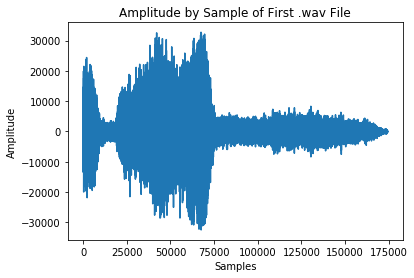

In [177]:
#plotting our first file 
plt.plot(data, '-', )
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Amplitude by Sample of First .wav File')
plt.show()

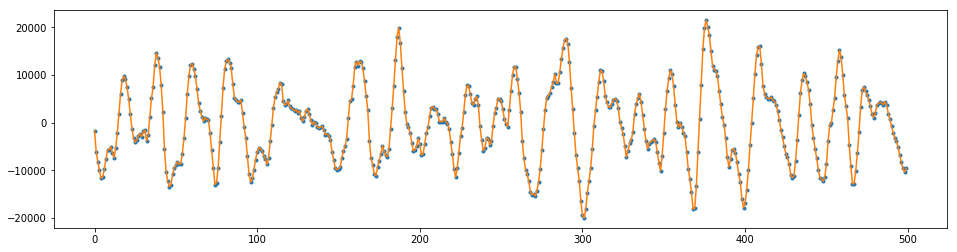

In [145]:
#Plotting the first 500 frames of our first audio file
plt.figure(figsize=(16, 4))
plt.plot(data[:500], '.');
plt.plot(data[:500], '-')
plt.show()

## Preprocessing

In [15]:
import librosa

In [146]:
def get_labels(path=data_path):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)

In [147]:
def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::1]
    mfcc = librosa.feature.mfcc(wave, sr=16000)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc


In [148]:
def save_data_to_array(path=data_path, max_len=11):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + '/'+ label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
        np.save(label + '.npy', mfcc_vectors)

In [149]:
def get_train_test(split_ratio=0.6, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(data_path)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)

In [180]:
X

matrix([[    0,     0,     0, ...,  3990,  4366,  4471],
        [    0,     9,    60, ...,  4353,  4618,  5065],
        [  203,   215,   214, ...,  1760,  1975,  1842],
        ...,
        [ -213,  -370,  -528, ..., -1338, -5617, -7393],
        [  244,   135,   525, ...,  4845,  5092,  5281],
        [-1660, -6080, -8146, ...,   317,   387,   146]], dtype=int16)

In [151]:
def prepare_dataset(path=data_path):
    labels, _, _ = get_labels(path)
    data = {}
    for label in labels:
        data[label] = {}
        data[label]['path'] = [path  + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]

        vectors = []

        for wavfile in data[label]['path']:
            wave, sr = librosa.load(wavfile, mono=True, sr=None)
            # Downsampling
            wave = wave[::3]
            mfcc = librosa.feature.mfcc(wave, sr=16000)
            vectors.append(mfcc)

        data[label]['mfcc'] = vectors

    return data


In [152]:
def load_dataset(path=data_path):
    data = prepare_dataset(path)

    dataset = []

    for key in data:
        for mfcc in data[key]['mfcc']:
            dataset.append((key, mfcc))

    return dataset[:100]

## Building and Fitting Our Model

In [153]:
# Second dimension of the feature is dim2
feature_dim_2 = 11

# Save data to array file first
save_data_to_array(max_len=feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
feature_dim_1 = 20
channel = 1
epochs = 50
batch_size = 100
verbose = 1
num_classes = 28

# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

Saving vectors of label - 'whistle': 100%|█████| 63/63 [00:01<00:00, 39.32it/s]


In [154]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Nadam(),
                  metrics=['accuracy'])
    return model

# Predicts one sample
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][
            np.argmax(model.predict(sample_reshaped))
    ]

In [155]:
model = get_model()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=50, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 2298 samples, validate on 1533 samples
Epoch 1/50
2298/2298 [==============================] - ETA: 38s - loss: 8.3920 - acc: 0.02 - ETA: 19s - loss: 6.9312 - acc: 0.03 - ETA: 13s - loss: 6.2493 - acc: 0.03 - ETA: 10s - loss: 5.5973 - acc: 0.02 - ETA: 8s - loss: 5.1952 - acc: 0.0320 - ETA: 7s - loss: 4.9080 - acc: 0.035 - ETA: 6s - loss: 4.7102 - acc: 0.034 - ETA: 5s - loss: 4.5529 - acc: 0.038 - ETA: 4s - loss: 4.4272 - acc: 0.040 - ETA: 4s - loss: 4.3250 - acc: 0.041 - ETA: 3s - loss: 4.2342 - acc: 0.043 - ETA: 3s - loss: 4.1540 - acc: 0.045 - ETA: 2s - loss: 4.0868 - acc: 0.046 - ETA: 2s - loss: 4.0290 - acc: 0.049 - ETA: 2s - loss: 3.9785 - acc: 0.052 - ETA: 1s - loss: 3.9350 - acc: 0.055 - ETA: 1s - loss: 3.8911 - acc: 0.060 - ETA: 1s - loss: 3.8530 - acc: 0.068 - ETA: 0s - loss: 3.8206 - acc: 0.069 - ETA: 0s - loss: 3.7914 - acc: 0.069 - ETA: 0s - loss: 3.7655 - acc: 0.072 - ETA: 0s - loss: 3.7394 - acc: 0.075 - 6s 3ms/step - loss: 3.7208 - acc: 0.0740 - val_loss: 3.2045

2298/2298 [==============================] - ETA: 3s - loss: 2.2877 - acc: 0.340 - ETA: 3s - loss: 2.2164 - acc: 0.390 - ETA: 3s - loss: 2.2373 - acc: 0.383 - ETA: 2s - loss: 2.2447 - acc: 0.365 - ETA: 2s - loss: 2.2803 - acc: 0.352 - ETA: 2s - loss: 2.3352 - acc: 0.336 - ETA: 2s - loss: 2.3417 - acc: 0.330 - ETA: 2s - loss: 2.3177 - acc: 0.341 - ETA: 2s - loss: 2.3388 - acc: 0.334 - ETA: 2s - loss: 2.3609 - acc: 0.329 - ETA: 1s - loss: 2.3539 - acc: 0.331 - ETA: 1s - loss: 2.3632 - acc: 0.330 - ETA: 1s - loss: 2.3592 - acc: 0.330 - ETA: 1s - loss: 2.3558 - acc: 0.329 - ETA: 1s - loss: 2.3473 - acc: 0.331 - ETA: 1s - loss: 2.3374 - acc: 0.333 - ETA: 0s - loss: 2.3455 - acc: 0.327 - ETA: 0s - loss: 2.3476 - acc: 0.328 - ETA: 0s - loss: 2.3526 - acc: 0.329 - ETA: 0s - loss: 2.3468 - acc: 0.328 - ETA: 0s - loss: 2.3406 - acc: 0.331 - ETA: 0s - loss: 2.3467 - acc: 0.330 - 4s 2ms/step - loss: 2.3461 - acc: 0.3329 - val_loss: 2.4384 - val_acc: 0.3268
Epoch 10/50
2298/2298 [==================

2298/2298 [==============================] - ETA: 3s - loss: 1.4303 - acc: 0.530 - ETA: 3s - loss: 1.5105 - acc: 0.500 - ETA: 3s - loss: 1.5165 - acc: 0.520 - ETA: 3s - loss: 1.4822 - acc: 0.512 - ETA: 2s - loss: 1.5030 - acc: 0.508 - ETA: 2s - loss: 1.5308 - acc: 0.503 - ETA: 2s - loss: 1.5667 - acc: 0.505 - ETA: 2s - loss: 1.5655 - acc: 0.505 - ETA: 2s - loss: 1.5722 - acc: 0.510 - ETA: 2s - loss: 1.5664 - acc: 0.514 - ETA: 1s - loss: 1.5726 - acc: 0.514 - ETA: 1s - loss: 1.5854 - acc: 0.512 - ETA: 1s - loss: 1.6018 - acc: 0.510 - ETA: 1s - loss: 1.5999 - acc: 0.510 - ETA: 1s - loss: 1.6066 - acc: 0.506 - ETA: 1s - loss: 1.6258 - acc: 0.501 - ETA: 0s - loss: 1.6249 - acc: 0.500 - ETA: 0s - loss: 1.6243 - acc: 0.499 - ETA: 0s - loss: 1.6193 - acc: 0.504 - ETA: 0s - loss: 1.6331 - acc: 0.503 - ETA: 0s - loss: 1.6405 - acc: 0.502 - ETA: 0s - loss: 1.6427 - acc: 0.502 - 4s 2ms/step - loss: 1.6554 - acc: 0.5000 - val_loss: 2.3080 - val_acc: 0.3764
Epoch 18/50
2298/2298 [==================

2298/2298 [==============================] - ETA: 3s - loss: 1.3211 - acc: 0.590 - ETA: 3s - loss: 1.2458 - acc: 0.620 - ETA: 3s - loss: 1.2211 - acc: 0.630 - ETA: 2s - loss: 1.1446 - acc: 0.657 - ETA: 2s - loss: 1.1236 - acc: 0.658 - ETA: 2s - loss: 1.1177 - acc: 0.663 - ETA: 2s - loss: 1.1240 - acc: 0.665 - ETA: 2s - loss: 1.1263 - acc: 0.666 - ETA: 2s - loss: 1.1216 - acc: 0.665 - ETA: 1s - loss: 1.1473 - acc: 0.659 - ETA: 1s - loss: 1.1380 - acc: 0.660 - ETA: 1s - loss: 1.1510 - acc: 0.655 - ETA: 1s - loss: 1.1649 - acc: 0.650 - ETA: 1s - loss: 1.1659 - acc: 0.647 - ETA: 1s - loss: 1.1673 - acc: 0.649 - ETA: 1s - loss: 1.1640 - acc: 0.649 - ETA: 0s - loss: 1.1563 - acc: 0.651 - ETA: 0s - loss: 1.1603 - acc: 0.650 - ETA: 0s - loss: 1.1599 - acc: 0.648 - ETA: 0s - loss: 1.1602 - acc: 0.650 - ETA: 0s - loss: 1.1647 - acc: 0.647 - ETA: 0s - loss: 1.1703 - acc: 0.646 - 4s 2ms/step - loss: 1.1677 - acc: 0.6493 - val_loss: 2.6344 - val_acc: 0.3744
Epoch 26/50
2298/2298 [==================

2298/2298 [==============================] - ETA: 3s - loss: 0.7974 - acc: 0.720 - ETA: 3s - loss: 0.8591 - acc: 0.750 - ETA: 3s - loss: 0.8555 - acc: 0.750 - ETA: 2s - loss: 0.8992 - acc: 0.737 - ETA: 2s - loss: 0.9186 - acc: 0.734 - ETA: 2s - loss: 0.8980 - acc: 0.733 - ETA: 2s - loss: 0.8694 - acc: 0.741 - ETA: 2s - loss: 0.8456 - acc: 0.745 - ETA: 2s - loss: 0.8803 - acc: 0.735 - ETA: 2s - loss: 0.8778 - acc: 0.737 - ETA: 1s - loss: 0.8946 - acc: 0.735 - ETA: 1s - loss: 0.9035 - acc: 0.733 - ETA: 1s - loss: 0.9067 - acc: 0.731 - ETA: 1s - loss: 0.8973 - acc: 0.733 - ETA: 1s - loss: 0.9027 - acc: 0.731 - ETA: 1s - loss: 0.8958 - acc: 0.727 - ETA: 0s - loss: 0.8884 - acc: 0.728 - ETA: 0s - loss: 0.8834 - acc: 0.730 - ETA: 0s - loss: 0.8807 - acc: 0.729 - ETA: 0s - loss: 0.8693 - acc: 0.733 - ETA: 0s - loss: 0.8787 - acc: 0.730 - ETA: 0s - loss: 0.8714 - acc: 0.730 - 4s 2ms/step - loss: 0.8649 - acc: 0.7328 - val_loss: 2.9041 - val_acc: 0.3712
Epoch 34/50
2298/2298 [==================

2298/2298 [==============================] - ETA: 3s - loss: 0.6860 - acc: 0.750 - ETA: 3s - loss: 0.6013 - acc: 0.765 - ETA: 3s - loss: 0.6812 - acc: 0.766 - ETA: 2s - loss: 0.6709 - acc: 0.777 - ETA: 2s - loss: 0.6868 - acc: 0.788 - ETA: 2s - loss: 0.6784 - acc: 0.795 - ETA: 2s - loss: 0.6752 - acc: 0.800 - ETA: 2s - loss: 0.6400 - acc: 0.813 - ETA: 2s - loss: 0.6592 - acc: 0.810 - ETA: 1s - loss: 0.6431 - acc: 0.811 - ETA: 1s - loss: 0.6708 - acc: 0.801 - ETA: 1s - loss: 0.6742 - acc: 0.795 - ETA: 1s - loss: 0.6715 - acc: 0.796 - ETA: 1s - loss: 0.6764 - acc: 0.795 - ETA: 1s - loss: 0.6768 - acc: 0.796 - ETA: 1s - loss: 0.6954 - acc: 0.791 - ETA: 0s - loss: 0.6975 - acc: 0.789 - ETA: 0s - loss: 0.7112 - acc: 0.784 - ETA: 0s - loss: 0.7181 - acc: 0.783 - ETA: 0s - loss: 0.7240 - acc: 0.783 - ETA: 0s - loss: 0.7287 - acc: 0.779 - ETA: 0s - loss: 0.7195 - acc: 0.781 - 4s 2ms/step - loss: 0.7134 - acc: 0.7842 - val_loss: 2.9802 - val_acc: 0.3725
Epoch 42/50
2298/2298 [==================

2298/2298 [==============================] - ETA: 3s - loss: 0.5018 - acc: 0.830 - ETA: 3s - loss: 0.6191 - acc: 0.795 - ETA: 3s - loss: 0.5479 - acc: 0.830 - ETA: 3s - loss: 0.5304 - acc: 0.837 - ETA: 2s - loss: 0.5220 - acc: 0.844 - ETA: 2s - loss: 0.5623 - acc: 0.828 - ETA: 2s - loss: 0.5844 - acc: 0.820 - ETA: 2s - loss: 0.5962 - acc: 0.818 - ETA: 2s - loss: 0.5911 - acc: 0.818 - ETA: 2s - loss: 0.5769 - acc: 0.821 - ETA: 1s - loss: 0.5737 - acc: 0.822 - ETA: 1s - loss: 0.5719 - acc: 0.820 - ETA: 1s - loss: 0.5691 - acc: 0.823 - ETA: 1s - loss: 0.5748 - acc: 0.822 - ETA: 1s - loss: 0.5635 - acc: 0.825 - ETA: 1s - loss: 0.5524 - acc: 0.828 - ETA: 0s - loss: 0.5512 - acc: 0.828 - ETA: 0s - loss: 0.5525 - acc: 0.827 - ETA: 0s - loss: 0.5542 - acc: 0.830 - ETA: 0s - loss: 0.5493 - acc: 0.831 - ETA: 0s - loss: 0.5533 - acc: 0.833 - ETA: 0s - loss: 0.5585 - acc: 0.832 - 4s 2ms/step - loss: 0.5518 - acc: 0.8346 - val_loss: 3.1376 - val_acc: 0.3653
Epoch 50/50
2298/2298 [==================

In [171]:
predict('AudioEventDataset/test/applause_164.wav',model)

'applause'

In [172]:
predict('AudioEventDataset/test/bird_261.wav',model)

'bird'

Our model has a final accuracy bordering closely to 83% in most iterations. 

In [197]:
X_train[233]

array([[-4.07509436e+02, -3.59173324e+02, -3.07783885e+02,
        -2.51872546e+02, -2.07779268e+02, -1.90364785e+02,
        -1.85831963e+02, -1.80115295e+02, -1.74134611e+02,
        -1.61330680e+02, -1.44512192e+02],
       [ 7.96741658e+01,  9.37160258e+01,  1.02364193e+02,
         9.28084171e+01,  6.64254368e+01,  4.99863786e+01,
         4.46291822e+01,  4.81750057e+01,  4.74270920e+01,
         4.69591498e+01,  4.98046659e+01],
       [ 1.53596281e+01, -8.82166556e+00, -3.92586336e+01,
        -4.97065870e+01, -4.85087316e+01, -4.89039510e+01,
        -5.31695117e+01, -5.05485235e+01, -4.48356264e+01,
        -4.17622291e+01, -4.01111123e+01],
       [ 9.78222286e+00,  9.75322020e+00,  9.04834271e+00,
         1.89716070e+01,  2.47039132e+01,  2.39251309e+01,
         2.42320769e+01,  2.83523978e+01,  2.71364585e+01,
         2.56629438e+01,  2.32949873e+01],
       [ 1.14942156e+01,  1.06596569e+01,  5.08347919e+00,
        -1.12936669e+01, -1.64215590e+01, -1.55537886e+01,
  